This code can calculate parameters below by regression:  
µ, maximum gross growth rate,$day^{-1}$  
kd, death rate,$day^{-1}$  
kla, $day^{-1}$  


Equations for batch experiments, constant aeration  
MLSS: $$\frac{dMLSS}{dt} = \mu*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS-kd*MLSS$$  
BOD: $$\frac{dBOD}{dt} = -\frac{\mu}{Y}*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS$$
DO: $$\frac{dDO}{dt} = -\frac{\mu}{Y}*\frac{S_{BOD}}{K_{BOD}+S_{BOD}}*\frac{S_{O_2}}{K_{O_2}+S_{O_2}}*MLSS+K_{L}a*(CS-S_{O_2})$$

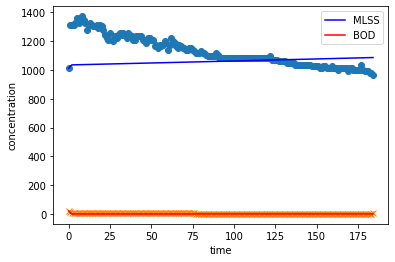

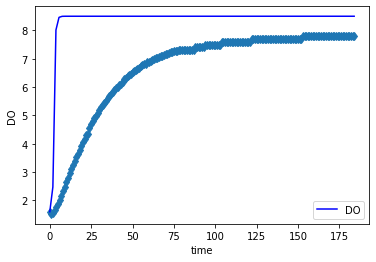

µ = 0.38218214335351147
kd = -0.00026420599180361216
kla = 1.3557171022404566


In [12]:
#kbod, BOD saturation constant, mg/L
kbod=20
#ko2,oxygen saturation constant, mg/L
ko2=0.1
#Y, growth yield coefficient, g cell/g BOD
Y=1.1
#CS,Saturated DO concentration,mg/L
CS=8.5

import csv
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt

time=[]
MLSS=[]
BOD=[]
DO=[]
with open('test data for simple model-1.csv',encoding='utf-8-sig') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time += [row[0]]
        MLSS += [row[1]]
        BOD += [row[4]]
        DO += [row[3]]
time = np.asfarray(time,float)
MLSS = np.asfarray(MLSS,float)
BOD = np.asfarray(BOD,float)
DO = np.asfarray(DO,float)

time=np.array(time[13:-1]-13)
MLSS =np.array(MLSS[13:-1])
BOD =np.array(BOD[13:-1])
DO =np.array(DO[13:-1])

xaxisData = np.array(time) 
yaxisData = np.array([MLSS,BOD,DO])

# Guesses for parameters
µguess = 0.005; 
kdguess = 0.0001; 
klaguess = 0.05; 
parameterGuesses = np.array([µguess,kdguess,klaguess])

#Define ODEs 
def ODE_definition(y,t,args): 
    y0 = y[0]
    y1 = y[1]
    y2 = y[2]
    µ = args[0]
    kd = args[1]
    kla = args[2]
    
    dy0dt = 𝜇*y1/(kbod+y1)*y2/(ko2+y2)*y0-kd*y0
    dy1dt = -𝜇/Y*y1/(kbod+y1)*y2/(ko2+y2)*y0
    dy2dt = -𝜇/Y*y1/(kbod+y1)*y2/(ko2+y2)*y0+kla*(CS-y2)
    return dy0dt, dy1dt, dy2dt

def ODEmodel(xaxisData,*params):
    yaxis0 = np.array([i[0] for i in yaxisData])
    numYaxisVariables = 3 
    yaxisOutput = np.zeros((xaxisData.size,numYaxisVariables)) 
    for i in np.arange(0,len(xaxisData)):
        xaxisIncrement = 0.001 
        xaxisSpan = np.arange(0,xaxisData[i]+xaxisIncrement,xaxisIncrement)
        y_calc = odeint(ODE_definition,yaxis0,xaxisSpan,args=(params,))
        yaxisOutput[i,:]=y_calc[-1,:]
        
    yaxisOutput = np.transpose(yaxisOutput)
    yaxisOutput = np.ravel(yaxisOutput)
    return yaxisOutput

parametersoln, pcov = curve_fit(ODEmodel,xaxisData,np.ravel(yaxisData),p0=parameterGuesses)

plt.figure(1)
plt.plot(xaxisData, yaxisData[0,:],'o') 
plt.plot(xaxisData, yaxisData[1,:],'x') 
xforPlotting = np.linspace(0,xaxisData[-1],100)
numYaxisVariables = 3
y_calculated = ODEmodel(xforPlotting,*parametersoln)
y_calculated = np.reshape(y_calculated,(numYaxisVariables,xforPlotting.size))
line1 =plt.plot(xforPlotting, y_calculated[0,:],'b-',label='MLSS') 
line2 =plt.plot(xforPlotting, y_calculated[1,:],'r-',label='BOD')  
plt.xlabel('time')
plt.ylabel('concentration')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(xaxisData, yaxisData[2,:],'d')
xforPlotting = np.linspace(0,xaxisData[-1],100)
numYaxisVariables = 3
y_calculated = ODEmodel(xforPlotting,*parametersoln)
y_calculated = np.reshape(y_calculated,(numYaxisVariables,xforPlotting.size))
line1 =plt.plot(xforPlotting, y_calculated[2,:],'b-',label='DO') 
plt.xlabel('time')
plt.ylabel('DO')
plt.legend()
plt.show()

print('µ =',parametersoln[0])
print('kd =',parametersoln[1])
print('kla =',parametersoln[2])